In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [2]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))

    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

In [3]:
Ds = [dp, dm]
Rs = [rp, rm]

n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

In [11]:
# First get two separate likelihoods
mPlus  = unf.model([dp], [rp], corr=np.diag([1]*4))
mMinus = unf.model([dm], [rm], corr=np.diag([1]*4))

In [12]:
Bplus  = mPlus.postFitUncerPOIs()
Bminus = mMinus.postFitUncerPOIs()

In [18]:
BplusIndep  = Bplus[0]
BminusIndep = Bminus[0]

In [19]:
print(BplusIndep)

[[7.95212628e+08 1.14590832e+07 1.14590832e+07]
 [7.92444149e+08 2.66447747e+07 2.61689752e+07]
 [7.92376284e+08 2.66424929e+07 2.61667341e+07]
 [7.95165482e+08 1.14584038e+07 1.14584038e+07]]


In [14]:
# Second, get one big likelihoods without correlations
m  = unf.model(Ds, Rs, corr=np.diag([1]*8))
Bs = m.postFitUncerPOIs()

In [20]:
BplusNoCorr  = Bs[0]
BminusNoCorr = Bs[1]

In [21]:
print(BplusIndep-BplusNoCorr)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [22]:
print(BminusIndep-BminusNoCorr)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.1920929e-07 0.0000000e+00 0.0000000e+00]
 [1.1920929e-07 0.0000000e+00 0.0000000e+00]]


In [25]:
def plotResult(xEdges, postFitPOIs):
    
    '''
    This function plot the post-fit unfolded bins 
    versus the unfolded observables values.
    
    xEdges: 1D array with edges of observable values
    postFitPOIs: 2D array of shape (N, 3) with N POI measurment
                 with central value, negative and positive error.
    '''
    
    # Plot the result
    plt.figure(figsize=(15, 5))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, distri in enumerate(postFitPOIs):
    
        # y-data
        vals = distri[:, 0]
        errn = distri[:, 1]
        errp = distri[:, 2]

        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(xCenter, vals, 'o', markersize=10)
        plt.hlines(y=vals, xmin=xDown, xmax=xUp, color='tab:blue')
        plt.vlines(x=xCenter, ymin=vals-errn, ymax=vals+errp, color='tab:blue')
        plt.ylabel('Unfolded Yields')
        plt.xlabel(xlabels[i])
        plt.ylim(7e8, 9e8)

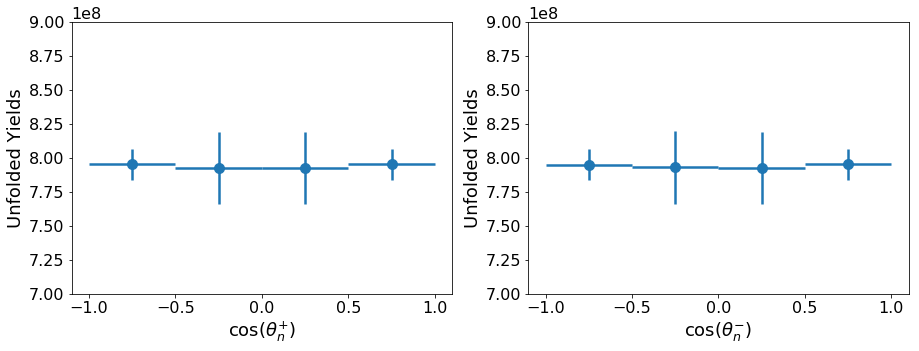

In [26]:
Xs = np.array([-1.0, -0.5, 0, 0.5, 1.0])
plotResult(Xs, Bs)

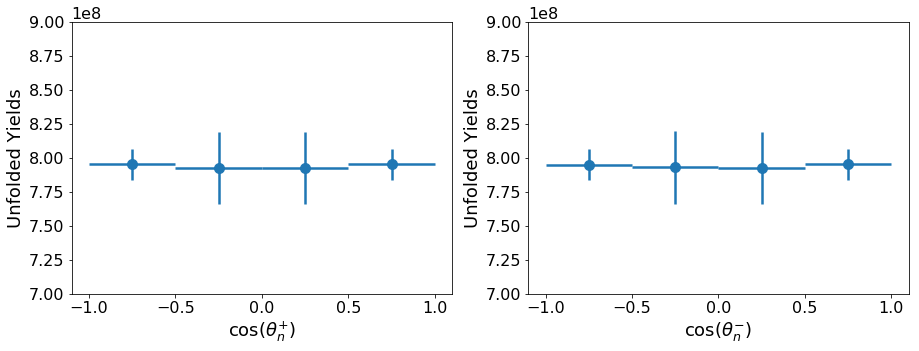

In [27]:
plotResult(Xs, [BplusIndep, BminusIndep])

In [46]:
def f(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def compareProfile(i, n=20):
    
    # New figure
    plt.figure()
    
    # Plot labels
    yLabel = '$\\Delta$ NLL'
    xLabel = 'cos$\\theta^{+}_{n}$' + '   bin {}'.format(i)
    if i>3 :
        xLabel = 'cos$\\theta^{-}_{n}$' + '   bin {}'.format(i-4) 
    
    # Run the Joint uncorrelated LH fit
    val1, nll1 = m.profilePOI(iPOI=i, POImin=0.74e9, POImax=0.85e9, nScan=n)
    p1, _ = optimize.curve_fit(f, val1, nll1)
    plt.plot(val1, nll1, 'o', color='tab:blue')
    v1 = np.linspace(val1.min(), val1.max(), 1000)
    n1 = f(v1, *p1)
    plt.plot(v1, n1, '--', color='tab:blue', label='Joint Uncorr LH')
    
    # Run the independent LH fit
    if i<4:
        val2, nll2 = mPlus.profilePOI(iPOI=i, POImin=0.74e9, POImax=0.85e9, nScan=n)
    else:
        val2, nll2 = mMinus.profilePOI(iPOI=i-4, POImin=0.74e9, POImax=0.85e9, nScan=n)
    p2, _ = optimize.curve_fit(f, val2, nll2)
    plt.plot(val2, nll2, 'o', color='tab:red')
    v2 = np.linspace(val2.min(), val2.max(), 1000)
    n2 = f(v2, *p2)
    plt.plot(v2, n2, '--', color='tab:red', label='Indep LH')
    
    # Add labels and legend
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend()

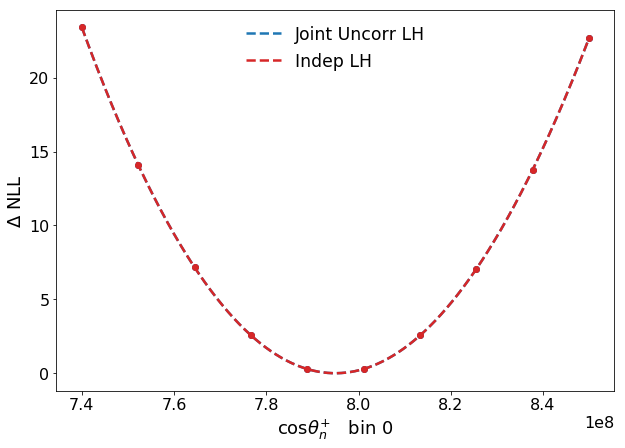

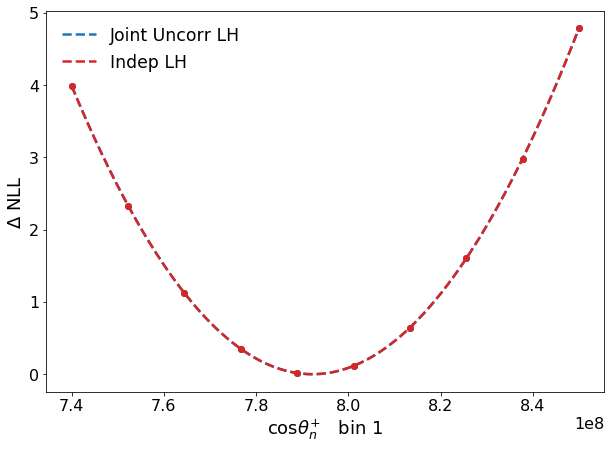

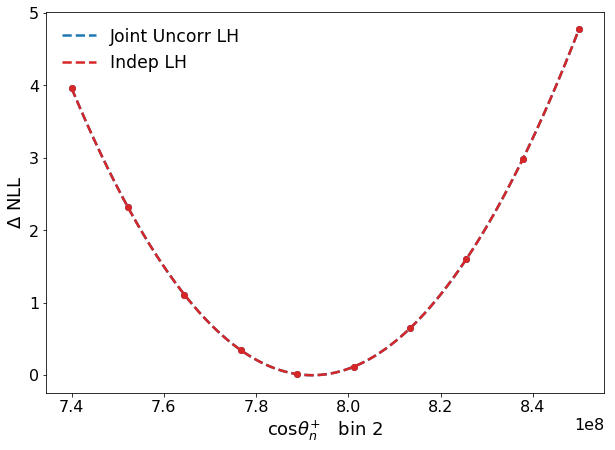

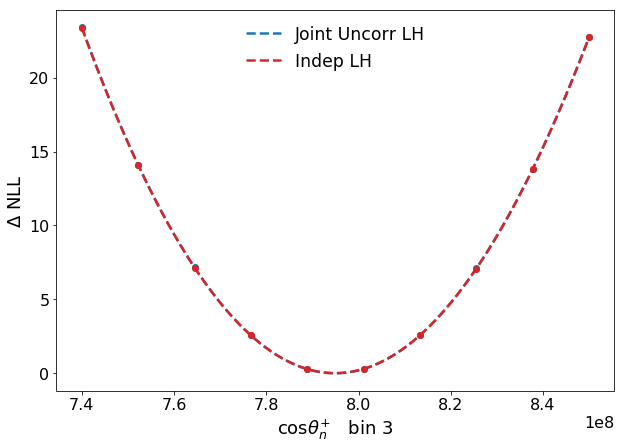

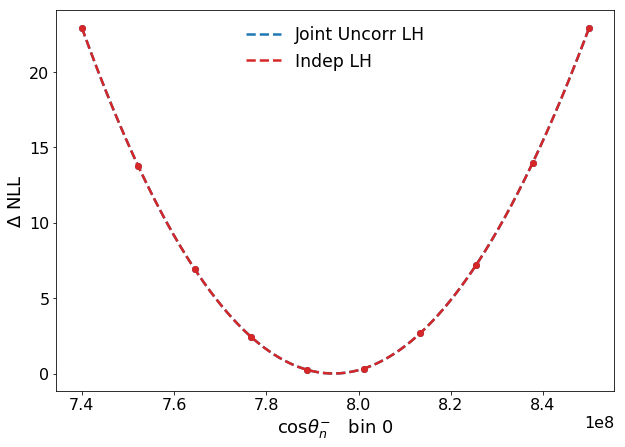

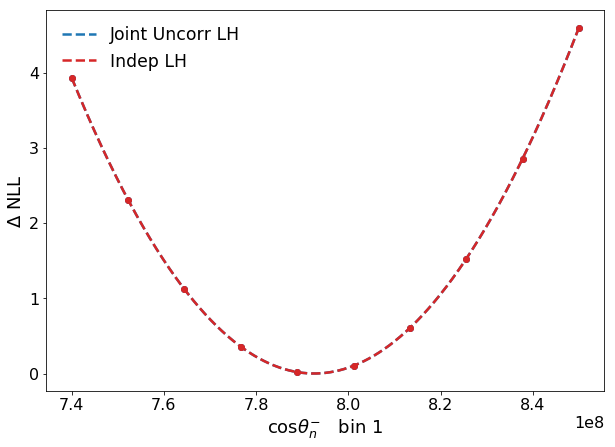

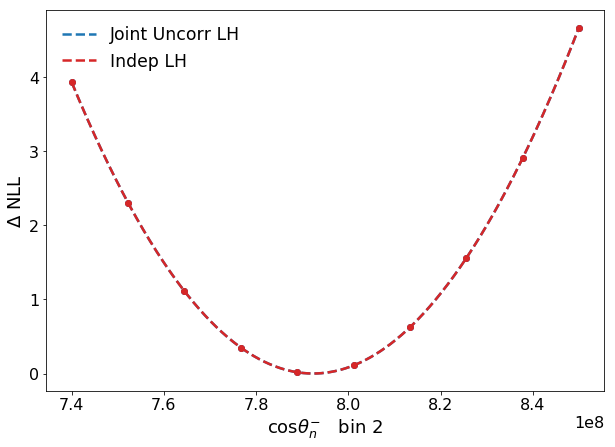

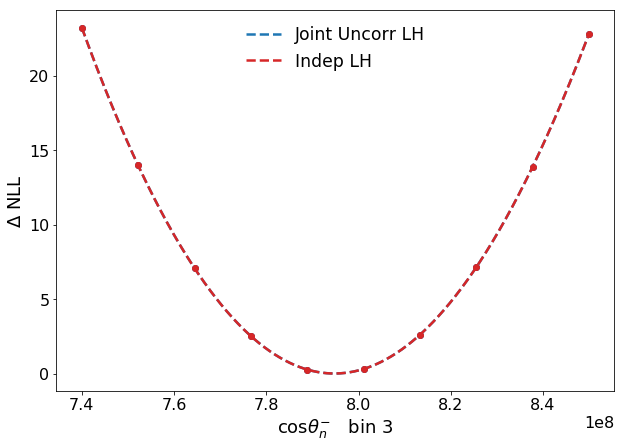

In [50]:
for i in range(8):
    compareProfile(i, n=10)